In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
%matplotlib inline
import imageio
from scipy.ndimage.interpolation import rotate
from math import cos, sin
import time
import random
import string
import optical_imaging as oi
import resistive_pulse as rp
import csv
import copy
from astroML.plotting import hist
pi=3.14159
import optical_imaging as oi
import oi_file
from sklearn.neighbors import KernelDensity
from scipy.ndimage.filters import gaussian_filter
from numpy.random import uniform

In [ ]:
title_size = 24
axislabel_size = 22
legendtitle_size = 18
axistick_size = 14
legendtext_size = 16
label_size = 16

import matplotlib.cm as cm
color_range=np.vstack((cm.Greys(np.linspace(0,1,10))[:-1], cm.Greys(np.linspace(1,0,10))))
print color_range


#font0 = FontProperties()
#font0.set_weight('bold')

# Get resistive pulse events

In [ ]:
directory = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/events/'

filepath_rp_events = directory + 'HCT116_pr0005_0000_rp_events_raw'

In [ ]:
events_rp = rp.open_event_file(filepath_rp)

In [ ]:
sigma = 15
for i, event in enumerate(events_rp):
    maxima, minima=rp.get_maxima_minima(event._data[:,1], sigma=sigma, refine_length=3, num_maxima = 2, num_minima = 3)
    event.set_extrema(maxima, minima)

In [ ]:
event = events_rp[0]


filt_data = gaussian_filter(event._data[:,1], sigma = sigma)
plt.plot(event._data[:,0], filt_data, c = 'black', lw = 3, zorder = 101)
plt.plot(event._data[:,0], event._data[:,1])
for i, extrema in enumerate(event._extrema):
    plt.scatter(event._data[extrema,0], event._data[extrema,1], c = 'red', s = 200, marker = 's', zorder = 100)
    
plt.xlim(event._data[0,0], event._data[-1,0])
plt.ylim(np.min(event._data[:,1]), np.max(event._data[:,1]))
    
plt.show()

In [ ]:
print len(events_rp)

# Get optical events

# Load events

In [ ]:
sampling_freq_oi = 10000

In [ ]:
reload(oi)
reload(oi_file)

vid_directory = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/vid/'
filepath_vid = vid_directory + 'HCT-116_pr0005_0000.mp4'

events_directory = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/events/'
filepath_events = events_directory+'hct-116_pr0005_0000_oi_events_raw'

events_oi_raw = oi_file.load_oi_events(filepath_events)

print len(events_oi_raw)

In [ ]:
events_oi = copy.deepcopy(events_oi_raw)

# Set up stage

In [ ]:
vid = oi_file.open_video_connection(filepath_vid)

In [ ]:
c0 = np.array([217, 160])
c1 = np.array([216, 145])
c2 = np.array([307, 140])
c3 = np.array([308, 155])

template_frame_num = 0
template_frame = oi.get_frame_vid(vid, template_frame_num)

stage = oi.Stage(template_frame, c0, c1, c2, c3)
stage.plot_stage()

# Event post-processing

In [ ]:
print len(events_oi)
events_oi = oi.connect_loose_events(copy.deepcopy(events_oi), tf_sep_threshold = 10, dist_threshold = 50)
print len(events_oi)

oi_file.save_oi_events('/home/preston/Desktop/Science/Research/cancer_cells/data/7-20-2016/events/psmix_0013_oi_events',
                   events_oi)

# Remove events that don't enter, exit channel

In [ ]:
for i, event in enumerate(events_oi):
    event.get_channel_enter_exit_tf(stage)
    
print len(events_oi)
events_oi = [event for event in events_oi if (event._channel_enter_tf != None) and (event._channel_exit_tf != None)]
print len(events_oi)

# Sort events by channel enter time

In [ ]:
order = np.argsort(np.array([event._channel_enter_tf for event in events_oi]))
events_oi = [copy.deepcopy(events_oi[i]) for i in order]

# Multievent plot

In [ ]:
for i, event in enumerate(events_oi[:]):
    plt.plot(event.get_px(), event.get_py())
    plt.imshow(template_frame, alpha=0.5, cmap = 'gray', origin = 'lower')
    plt.title(str(i))

    plt.show()

In [ ]:
keep_list = [0,1,2,4,5,6,7,8,10,11,12,14,15,18,19,20,21,22]
event_list = [events_oi[i] for i in range(len(events_oi)) if i in keep_list]

# Channel enter positions

In [ ]:
ypos = []
for i, event in enumerate(events_oi):
    x = event._detections[event._channel_enter_index]._px
    y = event._detections[event._channel_enter_index]._py
    ypos.append(stage.get_channel_coordinates(x,y)[1])

In [ ]:
for i, event in enumerate(events_oi):
    fig = plt.figure(figsize = (10,6))
    plt.imshow(oi.get_frame_vid(vid, int(event._channel_enter_tf)), cmap = 'gray')
    x = event._detections[event._channel_enter_index]._px
    y = event._detections[event._channel_enter_index]._py

    x_c, y_c = stage.get_channel_coordinates(x,y)
    plt.scatter(x,y, marker = 'x', color = 'red', s = 200)
    plt.text(0,0,str(event._channel_enter_tf), ha = 'left', va = 'top', size = 30)
    offset = 20
    plt.text(x+offset,y, '(' + str(x_c) + ',' + str(y_c) + ')', ha = 'left', va = 'center', color = 'red', size = 16)
    plt.show()
    print stage.get_channel_coordinates(x, y)

# Synchronize with resistive pulse data

In [ ]:
print .587*vid._meta['nframes']/10000.0

In [ ]:
for i, event in enumerate(events_rp):
    print i, event._data[0,0]

In [ ]:
fig = plt.figure(figsize = (1,100))
oi_match = 2
rp_match = 22
offset = -1.*events_oi[oi_match]._channel_enter_tf/sampling_freq_oi + events_rp[rp_match]._data[events_rp[rp_match]._extrema[0],0] 
#offset = 0


print 'rp:', len(events_rp)
for i, event in enumerate(events_rp):
    plt.scatter(1, event._data[event._extrema[0],0], c = 'red')
    plt.text(1, event._data[event._extrema[0],0], str(i), ha = 'right', va = 'center', color = 'red')

print 'oi:', len(events_oi)
for i, event in enumerate(events_oi):    
    plt.scatter(.5, 1.*event._channel_enter_tf/sampling_freq_oi+offset, c = 'blue')
    plt.text(.5, 1.*event._channel_enter_tf/sampling_freq_oi+offset, str(i), ha = 'left', va = 'center', color = 'blue')

plt.xlim(.4,1.1)
plt.ylim(0,10)
    
plt.show()




In [ ]:
plt.imshow(oi.get_frame_vid(vid, events_oi[41]._channel_enter_tf), cmap = 'gray')

# Pairs

In [ ]:
pairs = [
    (0,19),
    (1,21),
    (2,22),
    (3,23),
    (4,26),
    (6,27),
    (7,28),
    (8,29),
    (10,31),
    (11,32),
    (13,38),
    (14,39),
    (15,40),
    (16,41),
    (17,42),
    (20,43),
    (21,44)
]

# Plot synced OI and RP 

In [ ]:
for i, event in enumerate(events_oi):
    plt.imshow(oi.get_frame_vid(vid, event._channel_enter_tf), cmap = 'gray')
    plt.title(i)
    plt.show()

In [ ]:
for pair in pairs:
    
    event_oi = events_oi[pair[0]]
    event_rp = events_rp[pair[1]]
    
    
    fig = plt.figure(figsize = (12,6))
    
    gs=gridspec.GridSpec(2,2)
    
    
    
    plt.subplot(gs[0])
    plt.imshow(oi.get_frame_vid(vid, event_oi._channel_enter_tf), cmap = 'gray')
    plt.title(str(pair[0])+',' + str(1.*event_oi._channel_enter_tf/vid._meta['nframes']*9.))
    
    plt.subplot(gs[1])
    plt.plot(event_rp._data[:,0], event_rp._data[:,1])
    plt.title(str(pair[1]))
    
    plt.plot()
    plt.show()

# Entry position histograms

In [ ]:
fig = plt.figure(figsize = (8,6))
ys = []
for i, event in enumerate(events_oi):
    index = event._channel_enter_index
    x, y = stage.get_channel_coordinates(event._detections[index]._px, event._detections[index]._py)
    ys.append(y)

plt.hist(ys, bins = np.array([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])-0.5, color = (.2,.2,.2))

plt.title('Entry position frequency', size = title_size)
plt.xlabel('entry position (pix)', size = axislabel_size)
plt.ylabel('frequency', size = axislabel_size)



plt.tick_params(axis = 'both', which = 'major', labelsize = 16)

plt.savefig('/home/preston/Desktop/Science/Research/pore_stats/entry_positions_7-20-2016_psmix-0013.png', dpi = 300)

plt.show()

# Trajectory RP

In [ ]:
fig = plt.figure(figsize=(6, 12))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
index_1 = 46
for pair in pairs:
    if pair[0] == index_1:
        index_2 = pair[1]
event_oi = events_oi[index_1]
event_rp = events_rp[index_2]

#ax0 = fig.add_subplot(2,1,1)
ax0 = plt.subplot(gs[0])
plt.gca()

plt.imshow(template_frame, cmap = 'gray', aspect = 'auto', origin = 'lower')



tf_1 = int(event_oi._channel_enter_tf - event_oi._detections[0]._tf - (event_rp._extrema[0])/250000.0*10000.)

tf_2 = int(event_oi._channel_enter_tf - event_oi._detections[0]._tf + (event_rp._data.shape[0]-event_rp._extrema[0])/250000.0*10000.0)

trajectories = np.empty((tf_2-tf_1,2))

for i in range(tf_1, tf_2):
    trajectories[i-tf_1,0]=event_oi._detections[i]._px
    trajectories[i-tf_1,1]=event_oi._detections[i]._py


plt.plot(trajectories[:,0], trajectories[:,1])
    
plt.xlim(trajectories[0,0],trajectories[-1,0])
plt.ylim(34,90)

ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])

ax1 = plt.subplot(gs[1])
plt.gca()



plt.plot(event_rp._data[:,0], event_rp._data[:,1])

plt.xlim(event_rp._data[0,0], event_rp._data[-1,0])
plt.ylim(np.min(event_rp._data[:,1]), np.max(event_rp._data[:,1]))

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

transFigure = fig.transFigure.inverted()


"""
x0 = event_oi._detections[event_oi._channel_enter_index]._px
y0 = event_oi._detections[event_oi._channel_enter_index]._py
x1 = event_rp._data[event_rp._extrema[0],0]
y1 = event_rp._data[event_rp._extrema[0],1]
coord1 = transFigure.transform(ax0.transData.transform([x0,y0]))
coord2 = transFigure.transform(ax1.transData.transform([x1,y1]))


line = mpl.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
                               transform=fig.transFigure, c = 'red', lw = 3)
fig.lines.append(line)
"""

plt.tight_layout()

# Entry position vs. amplitude

In [ ]:
data = np.empty((len(pairs),2))

for i, pair in enumerate(pairs):
    event_oi = events_oi[pair[0]]
    event_rp = events_rp[pair[1]]
    
    amp = event_rp._data[:,1].max() - event_rp._data[:,1].min()
    
    
    index = event_oi._channel_enter_index
    x = event_oi._detections[index]._px
    y = event_oi._detections[index]._py
    xc, yc = stage.get_channel_coordinates(x,y)
    
    data[i,0] = yc
    data[i,1] = amp
    
fig = plt.figure(figsize = (8,6))
    
plt.scatter(data[:,0], data[:,1], c = 'black')

plt.xlabel('Entry position (pix)', size = axislabel_size)
plt.ylabel(r'Amplitude $\left(\mu A\right)$', size = axislabel_size)

plt.tick_params(axis = 'both', which = 'major', labelsize = axistick_size)

plt.grid()

plt.show()

# Entry y vs. translocation time scatter

In [ ]:
duration_list = []
sampling_freq_oi = 10000
yc = []
for i in range(len(events_oi)):
    duration_list.append(1.*(events_oi[i]._channel_exit_tf - events_oi[i]._channel_enter_tf)/sampling_freq_oi)
    
    x = events_oi[i]._detections[events_oi[i]._channel_enter_index]._px
    y = events_oi[i]._detections[events_oi[i]._channel_enter_index]._py
    yc.append(stage.get_channel_coordinates(x,y)[1])

fig = plt.figure(figsize = (8,6))
    
plt.scatter(yc, duration_list, c = 'black')

plt.xlim(-10,10)
plt.ylim(0,.01)

plt.title('Entry position vs translocation duration', size = title_size)

plt.tick_params(axis = 'both', which = 'major', labelsize = axistick_size)

plt.xlabel('Entry position (pix)', size = axislabel_size)
plt.ylabel('Duration (s)', size = axislabel_size)

plt.grid()

plt.show()

# x vs. t plot

In [ ]:
import matplotlib as mpl

In [ ]:
fig = plt.figure(figsize = (8,6))

Z = [[0,0],[0,0]]
levels = range(0,14)


cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', color_range)



CS3 = plt.contourf(Z, levels, cmap = cmap)




plt.clf()


for i, event in enumerate(events_oi[:]):
    i1 = event._channel_enter_index
    i2 = event._channel_exit_index
    px = event.get_px()
    py = event.get_py()
    xcs = []
    for j in range(i1,i2):
        xc, yc = stage.get_channel_coordinates(px[j], py[j])
        xcs.append(xc)
        if j == i1:
            enter_yc = yc+8
            
    

    plt.plot(1.*(np.array(event.get_tf()[i1:i2]) - event._detections[i1]._tf)/sampling_freq_oi, xcs,\
             color = color_range[int(enter_yc)-1],\
             zorder = 100)
    
    
    
plt.tick_params(axis = 'both', which = 'major', labelsize = axistick_size)
    
plt.title('axis position vs time', size = title_size)
plt.xlabel('t (s)', size = axislabel_size)
plt.ylabel('x (pix)', size = axislabel_size)
plt.grid()



plt.colorbar(CS3)



plt.show()

# v vs. t plot

In [ ]:
for i, event in enumerate(events_oi[:10]):
    i1 = event._channel_enter_index
    i2 = event._channel_exit_index
    px = event.get_px()
    py = event.get_py()
    xcs = []
    for j in range(i1,i2):
        xc, yc = stage.get_channel_coordinates(px[j], py[j])
        xcs.append(xc)
        if j == i1:
            enter_yc = yc+8
            
    vs = []
    for j in range(1, i2-i1-1):
        vs.append(((xcs[j+1] - xcs[j])+(xcs[j+1] - xcs[j-1])/2.)/2.)
        

    

    plt.plot(1.*(np.array(event.get_tf()[i1+1:i2-1]) - event._detections[i1]._tf)/sampling_freq_oi, vs)
    
    plt.xlabel('time (s)')
    plt.ylabel('')
    plt.show()

# Animation

In [172]:
index = 1
event_oi = events_oi[pairs[index][0]]
event_rp = events_rp[pairs[index][1]]

In [173]:
i_oi_0 = event_oi._channel_enter_tf - 20
i_oi_1 = event_oi._channel_enter_tf
i_oi_2 = event_oi._channel_exit_tf + 20


i_rp_1 = int(event_rp._data[event_rp._extrema[0],0]*250000.0)
i_rp_0 = int(i_rp_1 - (i_oi_1 - i_oi_0)*250000.0/10000.0)
i_rp_2 = int(i_rp_1 + (i_oi_2 - i_oi_1)*250000.0/10000.0)

filepath_rp = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/bts/HCT116_pr0005_0000.bts'
data_rp = rp_file.get_data(filepath_rp)

In [174]:
trajectories = np.empty((i_oi_2-i_oi_0,2))
for i, detection in enumerate(event_oi._detections[i_oi_0:i_oi_2]):
    trajectories[i,:] = np.array([detection._px, detection._py])
print trajectories

[[  6.93442948e-310   6.93442948e-310]
 [  2.10077583e-312   2.35541533e-312]
 [  2.22809558e-312   2.44029516e-312]
 [  1.29441743e-312   2.33419537e-312]
 [  9.76118064e-313   2.31297541e-312]
 [  2.46151512e-312   8.48798317e-313]
 [  2.22809558e-312   2.35541533e-312]
 [  2.01589600e-312   9.54898106e-313]
 [  2.01589600e-312   2.22809558e-312]
 [  1.01855798e-312   1.06099790e-312]
 [  8.70018274e-313   2.16443571e-312]
 [  2.41907520e-312   2.22809558e-312]
 [  6.79038653e-313   2.14321575e-312]
 [  2.14321575e-312   2.46151512e-312]
 [  2.35541533e-312   6.79038654e-313]
 [  2.33419537e-312   2.14321575e-312]
 [  2.48273508e-312   2.14321575e-312]
 [  2.05833592e-312   2.14321575e-312]
 [  2.14321575e-312   2.14321575e-312]
 [  2.46151512e-312   2.35541533e-312]
 [  9.76118064e-313   2.12199579e-312]
 [  2.46151512e-312   2.10077583e-312]
 [  2.22809558e-312   2.33419537e-312]
 [  1.93101617e-312   2.01589600e-312]
 [  2.22809558e-312   1.01855798e-312]
 [  2.22809558e-312   2.3

In [175]:
def get_rp_index(oi_index, oi_sync_index, rp_sync_index, oi_sampling_freq, rp_sampling_freq):
    return int(rp_sync_index + 1.*(oi_index - oi_sync_index)/oi_sampling_freq*rp_sampling_freq)

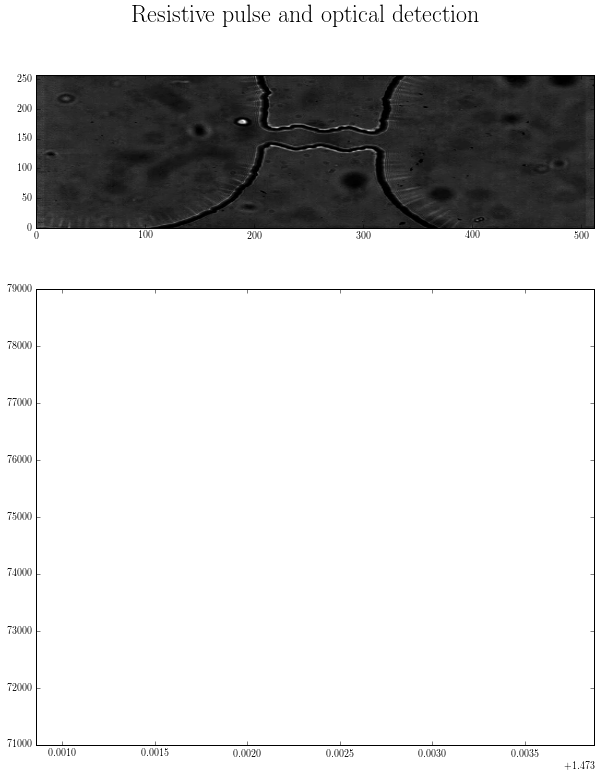

In [176]:
# Set up figure and subplots
fig = plt.figure(num = 0, figsize = (10,12))
fig.suptitle('Resistive pulse and optical detection', fontsize = 24)

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.grid(False)
ax1.grid(False)

# Initialize plot0
plot0_0 = ax0.imshow(oi.get_frame_vid(vid, event_oi._detections[0]._tf), cmap = 'gray', aspect = 'auto', origin = 'lower')
plot0_1, = ax0.plot(0,0, color = (1.,0,0), zorder = 100)
plot0_0.axes.set_xlim(0, template_frame.shape[1])
plot0_0.axes.set_ylim(0, template_frame.shape[0])
plot0_1.axes.set_xlim(0, template_frame.shape[1])
plot0_1.axes.set_ylim(0, template_frame.shape[0])

# Initialize plot1
plot1, = ax1.plot(event_rp._data[0,0], event_rp._data[0,1])
plot1.axes.set_xlim(event_rp._data[0,0], event_rp._data[-1,0])


def get_frame_data(frame):
    print frame
    
    # Set data for plot0

    plot0_0.set_data(oi.get_frame_vid(vid, frame))  
    print trajectories[:frame-i_oi_0,:]
    plot0_1.set_data(trajectories[:frame-i_oi_0,1],trajectories[:1.*frame-i_oi_0,0])
  

    
    
    # Set data for plot1
    index_rp = get_rp_index(frame, i_oi_1, i_rp_1, 10000, 250000)
    plot1.set_data(data_rp[i_rp_0:index_rp,0], data_rp[i_rp_0:index_rp,1])
    plot1.axes.set_xlim(data_rp[i_rp_0, 0], data_rp[i_rp_2, 0])
    plot1.axes.set_ylim(event_rp._data[:,1].min(), event_rp._data[:,1].max())
    
    
    return plot0_0, plot0_1, plot1

In [177]:
ffmpeg_bin='/home/preston/ffmpeg-3.0.2-64bit-static/ffmpeg'
plt.rcParams['animation.ffmpeg_path']=ffmpeg_bin
video = animation.FuncAnimation(fig, get_frame_data, np.arange(i_oi_0, i_oi_2, 1))
writer=animation.FFMpegWriter()
video.save(filename = 'HCT-116_pr0005_0000_' + str(index) + '.mp4', writer = writer, fps = 60)

1366
[]
1366
[]


/home/preston/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1367
[[  6.93442948e-310   6.93442948e-310]]
1368
[[  6.93442948e-310   6.93442948e-310]
 [  2.10077583e-312   2.35541533e-312]]
1369
[[  6.93442948e-310   6.93442948e-310]
 [  2.10077583e-312   2.35541533e-312]
 [  2.22809558e-312   2.44029516e-312]]
1370
[[  6.93442948e-310   6.93442948e-310]
 [  2.10077583e-312   2.35541533e-312]
 [  2.22809558e-312   2.44029516e-312]
 [  1.29441743e-312   2.33419537e-312]]
1371
[[  6.93442948e-310   6.93442948e-310]
 [  2.10077583e-312   2.35541533e-312]
 [  2.22809558e-312   2.44029516e-312]
 [  1.29441743e-312   2.33419537e-312]
 [  9.76118064e-313   2.31297541e-312]]
1372
[[  6.93442948e-310   6.93442948e-310]
 [  2.10077583e-312   2.35541533e-312]
 [  2.22809558e-312   2.44029516e-312]
 [  1.29441743e-312   2.33419537e-312]
 [  9.76118064e-313   2.31297541e-312]
 [  2.46151512e-312   8.48798317e-313]]
1373
[[  6.93442948e-310   6.93442948e-310]
 [  2.10077583e-312   2.35541533e-312]
 [  2.22809558e-312   2.44029516e-312]
 [  1.29441743e-312   2

In [178]:
print event_oi._detections[-1]._tf
print event_oi._detections[0]._tf

1627
920
